In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from kaggle.api.kaggle_api_extended import KaggleApi
import kagglehub

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from minisom import MiniSom

os.environ["OMP_NUM_THREADS"]="7"

In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
!chcp 65001
path = %pwd

Active code page: 65001


In [4]:
api.dataset_download_files("dwdkills/alcohol-consumption-in-russia", path = path, unzip = True)

Dataset URL: https://www.kaggle.com/datasets/dwdkills/alcohol-consumption-in-russia


In [5]:
os.listdir()

['.ipynb_checkpoints', 'russia_alcohol.csv', 'Untitled.ipynb']

In [6]:
df = pd.read_csv('russia_alcohol.csv')
df.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


In [7]:
df = df.dropna()

In [8]:
regions = df['region'].values
df_numeric = df.select_dtypes(np.number)

In [9]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_numeric)

In [10]:
som_shape = (10,10)
input_len = df_numeric.shape[1]
som = MiniSom(x=som_shape[0], y=som_shape[1], input_len=input_len, sigma=0.5, learning_rate=0.0001)

In [11]:
som.random_weights_init(data_scaled)
som.train_random(data_scaled, 100)

Text(0.5, 1.0, 'U-матрица (Топографическая карта SOM)')

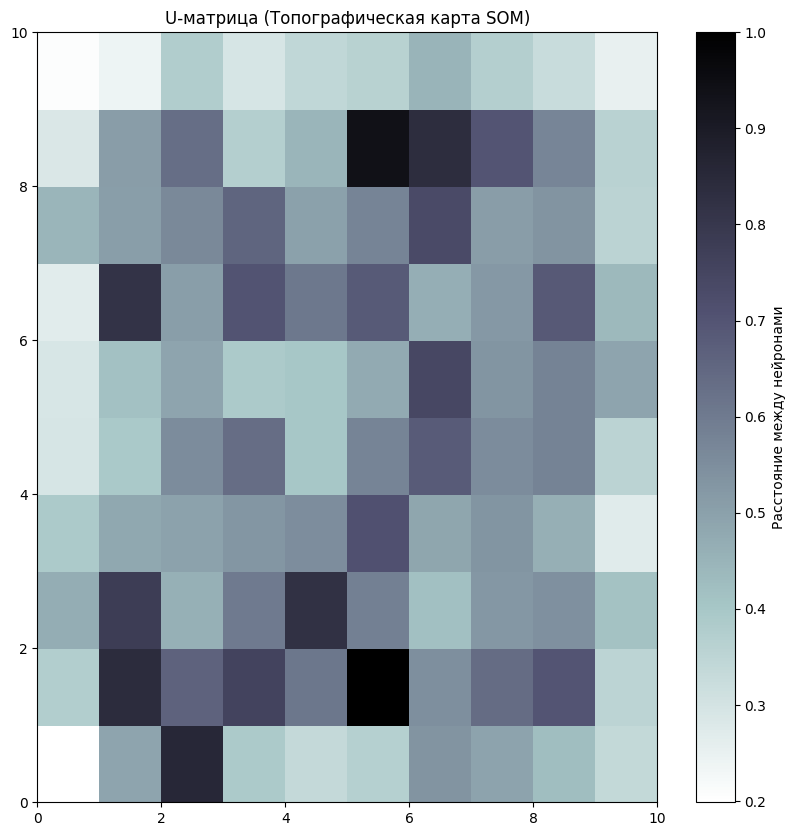

In [12]:
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # U-матрица
plt.colorbar(label='Расстояние между нейронами')
plt.title('U-матрица (Топографическая карта SOM)')

In [13]:
winner_coordinates = np.array([som.winner(x) for x in data_scaled])
cluster_map = {tuple(coord): idx for idx, coord in enumerate(np.unique(winner_coordinates, axis=0))}
labels_som = np.array([cluster_map[tuple(coord)] for coord in winner_coordinates])

In [14]:
silhouette_scores = []
cluster_range = range(2, 11) 

In [15]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)
    print(f"K = {k} коэффициент силуэта: {score:.4f}")

D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with M

K = 2 коэффициент силуэта: 0.3972
K = 3 коэффициент силуэта: 0.3665
K = 4 коэффициент силуэта: 0.3029
K = 5 коэффициент силуэта: 0.2842
K = 6 коэффициент силуэта: 0.2456
K = 7 коэффициент силуэта: 0.2518
K = 8 коэффициент силуэта: 0.2423
K = 9 коэффициент силуэта: 0.2142
K = 10 коэффициент силуэта: 0.2180


D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with M

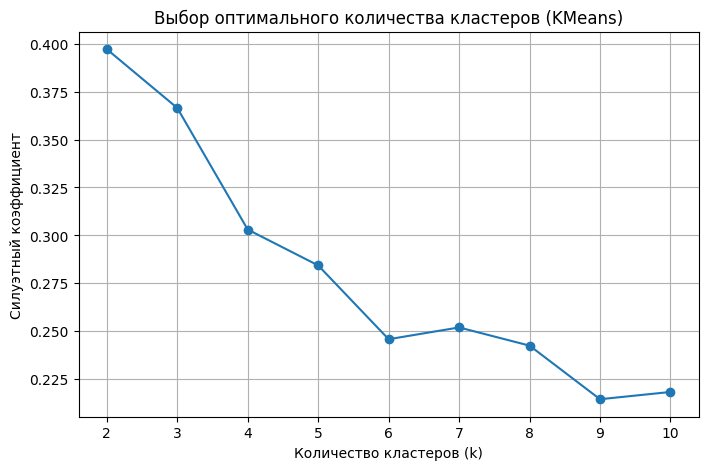

In [16]:
# === Визуализация ===
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Силуэтный коэффициент")
plt.title("Выбор оптимального количества кластеров (KMeans)")
plt.grid(True)
plt.show()

In [17]:
k_best = cluster_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=k_best, random_state=42)
labels_kmeans = kmeans.fit_predict(data_scaled)

D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [18]:
comparison_df = pd.DataFrame({
    'Регион': regions,
    'Кластер_SOM': labels_som,
    'Кластер_KMeans': labels_kmeans
})

In [19]:
print(len(comparison_df['Кластер_SOM'].unique()))
print(len(comparison_df['Кластер_KMeans'].unique()))

100
2


IndexError: boolean index did not match indexed array along axis 0; size of axis is 1549 but size of corresponding boolean axis is 100